In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=1)
sns.set_style('ticks',{'axes.grid' : False})

In [3]:
D = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_NM/gmm_model_select/gmmfits_combined_aT_1_0_aE_1_0_cs_1_0_ad_1_ld_3_ne_1500_ft_500_fiton_zT.csv')

In [4]:
field_name = 'bic_train'
X_mean = D.groupby('n_components').mean()[[field_name]]
X_sd = D.groupby('n_components').std()[[field_name]]
best_n_components = X_mean[field_name].idxmin()

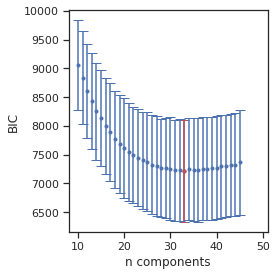

In [5]:
save_pth = '/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/'

plt.figure(figsize=(4,4))
plt.errorbar(x=X_mean.index.values,
             y=X_mean[field_name].values,
             yerr=X_sd[field_name].values,
             fmt='.',
             capsize=5)

plt.errorbar(x=best_n_components,
             y=X_mean[field_name][best_n_components],
             yerr=X_sd[field_name][best_n_components],
             fmt='.',
             c='r',
             capsize=3)

ax = plt.gca()
ax.set_xlabel('n components')
ax.set_ylabel('BIC')
#ax.set_ylim(1000,5600)
ax.set_xlim(8,51)
ax.set_xticks(np.arange(10,51,10))
plt.tight_layout()
#plt.savefig(save_pth+'denovo_gmm_bic.png',dpi=300)

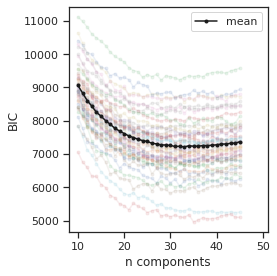

In [6]:
n_component_list=[]
plt.figure(figsize=(4,4))
for cv in range(44):
    Dd = D[D['cv']==cv]
    plt.plot(Dd['n_components'],Dd[field_name],'.-',alpha=0.1)
    temp = Dd.loc[Dd[field_name]==Dd[field_name].min()]
    n_component_list.append(temp['n_components'].values[0])
plt.plot(X_mean.index.values,X_mean[field_name].values,'.-',c='k',label='mean')
ax = plt.gca()
ax.set_xlabel('n components')
ax.set_ylabel('BIC')
#ax.set_ylim(1000,5600)
ax.set_xlim(8,51)
ax.set_xticks(np.arange(10,51,10))
plt.legend()
plt.tight_layout()
#plt.savefig(save_pth+'aT_1_0_aE_1_0_cs_1_0_us_bic_cvsets.png',dpi=300)

**Freedman-Diaconis rule** 

bin width $h = 2\times{IQ}\times{n^{−\frac{1}{3}}}$
 - IQ is the interquartile range
 - n is number of observations

In [7]:
from scipy.stats import iqr
FD_binwidth = 2*iqr(n_component_list)*(len(n_component_list))**(-1/3)

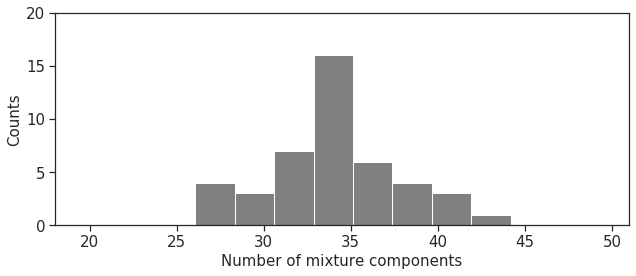

In [8]:
yy = n_component_list
plt.figure(figsize=(9,4))
plt.hist(yy,bins=np.arange(16.5,50,FD_binwidth)+0.5,color='gray')
ax = plt.gca()
ax.set_xlabel('Number of mixture components',fontsize=15)
ax.set_ylabel('Counts',fontsize=15)
ax.set_ylim(0,20)
ax.set_xlim(18,51)
ax.set_yticks(np.arange(0,21.5,5))
ax.set_yticklabels(np.arange(0,21.5,5).astype(int),fontsize=15)
ax.set_xticks(np.arange(20,51,5))
ax.set_xticklabels(ax.get_xticks(),fontsize=15)
plt.tight_layout()
#plt.savefig(save_pth+'gmm_aT_1_0_aE_1_0_cs_1_0_ad_1_us_bic_hist.png',dpi=300)
plt.show()

In [9]:
#For multiple iterations, same cvset

import re
import glob
#fname_list = glob.glob('/home/common/Rohan/Remote-AI/dat/result/TE_NM_cc/gmm_model_select_cv_0/gmmfit_restricted_perc_100-0_aT_1-0_aE_1-0_cs_1-0_ad_1*.csv')
fname_list = glob.glob('/home/common/Rohan/Remote-AI/dat/result/TE_NM_cc/gmm_model_select_cv_0_fiton_zTzE/gmmfit_restricted_perc_100-0_aT_1-0_aE_1-0_cs_1-0_ad_1*.csv')

df_list = []
for fname in fname_list:
    df=pd.read_csv(fname)
    result = re.search('cv_0_ri_(.*)_ld_3', fname)
    ri = result.group(1)
    df['ri']=int(ri)
    df_list.append(df)
D = pd.concat(df_list)

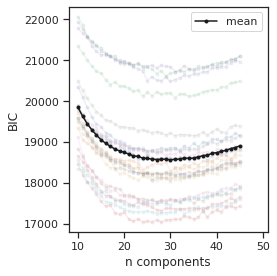

In [10]:
n_component_list=[]
field_name = 'bic_train'
X_mean = D.groupby('n_components').mean()[[field_name]]
X_sd = D.groupby('n_components').std()[[field_name]]
best_n_components = X_mean[field_name].idxmin()

plt.figure(figsize=(4,4))
for ri in range(21):
    Dd = D[D['ri']==ri].copy(deep=True)
    Dd.sort_values(by='n_components',inplace=True)
    plt.plot(Dd['n_components'],Dd[field_name],'.-',alpha=0.1)
    temp = Dd.loc[Dd[field_name]==Dd[field_name].min()]
    n_component_list.append(temp['n_components'].values[0])
plt.plot(X_mean.index.values,X_mean[field_name].values,'.-',c='k',label='mean')
ax = plt.gca()
ax.set_xlabel('n components')
ax.set_ylabel('BIC')
#ax.set_ylim(1000,5600)
ax.set_xlim(8,51)
ax.set_xticks(np.arange(10,51,10))
plt.legend()
plt.tight_layout()

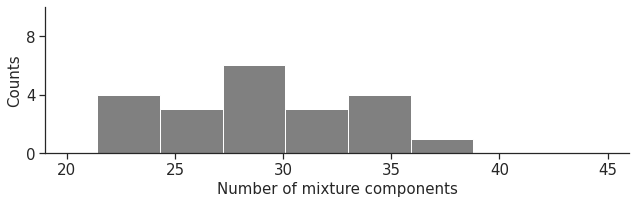

In [11]:
save_pth = '/home/common/Rohan/docs/'
from scipy.stats import iqr
FD_binwidth = 2*iqr(n_component_list)*(len(n_component_list))**(-1/3)
yy = n_component_list
plt.figure(figsize=(9,3))
plt.hist(yy,bins=np.arange(18.0,50,FD_binwidth)+0.5,color='gray')
ax = plt.gca()

ax.set_ylabel('Counts',fontsize=15)
ax.set_ylim(0,10)
ax.set_yticks(np.arange(0,10,4))
ax.set_yticklabels(ax.get_yticks(),fontsize=15)

ax.set_xlabel('Number of mixture components',fontsize=15)
ax.set_xlim(19,46)
ax.set_xticks(np.arange(20,46,5))
ax.set_xticklabels(ax.get_xticks(),fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(save_pth+'gmm_fiton_zTzE_aT_1_0_aE_1_0_cs_1_0_ad_1_us_bic_hist_21_inits.png',dpi=300)
plt.show()

**Get heatmaps for consensus clusters**

In [1]:
# load fitted gmm model from file
from sklearn import mixture
import scipy.io as sio
import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timebudget import timebudget
from tqdm import tqdm
from os.path import isfile
from copy import deepcopy
%matplotlib inline

In [2]:
def confusion(a,b,unique_a,unique_b):
    """
    `a`, `b` : numpy arrays of labels for all the element.
    `unique_a`, `unique_b` : unique list of labels. Can have more entries than np.unique(a) and np.unique(b) 
    """
    assert a.shape==b.shape
    C = np.zeros((np.size(unique_a),np.size(unique_b)))
    for i,la in enumerate(unique_a):
        for j,lb in enumerate(unique_b):
            C[i,j] = np.sum(np.logical_and(a==la,b==lb))
    return C


def get_merged_ordered_classes(data_labels,n_required_classes=30):
    """
    Exits when number of labels in the data matches or is just 
    above the required number of classes.
    
    returns:
    
    """
    from analysis_tree_helpers import HTree, do_merges

    #Load inhibitory subtree
    htree = HTree(htree_file='/home/rohan/Remote-AI/dat/raw/patchseq-v4/dend_RData_Tree_20181220.csv')
    subtree = htree.get_subtree(node='n59')
    L = subtree.get_mergeseq()
    
    #Init:
    n_remain_classes = np.unique(data_labels).size
    n = 0
    
    while n_remain_classes>n_required_classes:
        n = n+1
        merged_sample_labels = do_merges(labels=data_labels.copy(), list_changes=L, n_merges=n, verbose=False)
        n_remain_classes = np.unique(merged_sample_labels).size
        
    if n_remain_classes!=n_required_classes:
        print('WARNING: Merges for required number of classes not found. Returning a higher number of classes')
        n = n-1
        
    new_data_labels = do_merges(labels=data_labels, list_changes=L, n_merges=n, verbose=False)
    print('Performed {:d} merges. Remaining classes in data = {:d}'.format(n,np.unique(new_data_labels).size))
    assert np.all(np.isin(np.unique(new_data_labels),subtree.child)), "Merged labels are not listed as children in tree"

    ind = np.isin(subtree.child,np.unique(new_data_labels))
    remain_class_names = subtree.child[ind]
    remain_class_x = subtree.x[ind]
    remain_class_names = sorted(list(set(zip(remain_class_names,remain_class_x))),key=lambda x:x[1])
    class_order = [n[0] for n in remain_class_names]
    return new_data_labels,class_order


def custom_heatmap(M,xdat,ydat,xdat_label_order,ydat_label_order,
                    xlabels=None,ylabels=None,
                    fig_width=9,fig_height=8,
                    vmin=0,vmax=100,):
    """
    `M` : Confusion matrix. Rows plotted on y axis, cols plotted on x-axis
    `xdat`,`ydat` : numpy arrays from which counts will be obtained
    `xdat_label_order`, `ydat_label_order` : order with which the histograms are plotted. Should match ordering of `M`
    """
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    import seaborn as sns
    sns.set(style='white')

    if xlabels is None:
        xlabels=['']*M.shape[1]
    if ylabels is None:
        ylabels=['']*M.shape[0]
        
    fig = plt.figure(figsize = (fig_width,fig_height),constrained_layout=True)
    gs = GridSpec(4, 4, figure=fig)
    ax1 = fig.add_subplot(gs[1:, 1:])
    ax2 = fig.add_subplot(gs[0, 1:])
    ax3 = fig.add_subplot(gs[1:, 0])

    sns.heatmap(M,annot=False,vmin=vmin,vmax=vmax,cbar_kws={"aspect":30,"shrink":.5,"use_gridspec":False,"location":"right"},ax=ax1,)
    ax1.set_yticks(np.arange(0,M.shape[0])+0.5)
    ax1.set_yticklabels(ylabels,rotation=0)

    ax1.set_xticks(np.arange(M.shape[1])+0.5)
    ax1.set_xticklabels(xlabels,rotation=90)
    ax1.xaxis.set_ticks_position('top')
    ax1.yaxis.set_ticks_position('left')

    sns.countplot(x=xdat,order=xdat_label_order,ax=ax2,color='grey')
    ax2.tick_params(labelbottom=False, labelleft=False)
    ax2.set_ylabel('')
    ax2.spines["left"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)

    sns.countplot(y=ydat,order=ydat_label_order,ax=ax3,color='grey')
    ax3.invert_xaxis()
    ax3.yaxis.set_ticks_position('right')
    ax3.tick_params(labelbottom=False, labelleft=False,labelright=False)
    ax3.set_ylabel('')
    ax3.set_xlabel('')
    ax3.spines["left"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["bottom"].set_visible(False)

    plt.show()
    
    
def custom_scatterplot(M,xlabels,ylabels,fig_width=10,fig_height=14,scale_factor=10.0):
    Mplot = M.copy()*scale_factor
    Mplot = np.flip(Mplot, axis=0)
    ylabels.reverse()
    x=np.arange(0, M.shape[1], 1)
    y=np.arange(0, M.shape[0], 1)
    xx,yy=np.meshgrid(x,y)
    plt.figure(figsize=(fig_width,fig_height))
    plt.scatter(np.ravel(xx),np.ravel(yy),s=np.ravel(Mplot),c='dodgerblue')
    ax=plt.gca()
    ax.set_xlim(np.min(x)-0.5,np.max(x)+0.5)
    ax.set_ylim(np.min(y)-0.5,np.max(y)+0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels,rotation=90)
    ax.set_yticks(y)
    ax.set_yticklabels(ylabels,rotation=0)
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    
    ax.tick_params(color='None')
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    
    for tick in ax.get_yticklabels():
        #tick.set_fontname("DejaVu Sans Mono")
        tick.set_fontfamily('monospace')
        tick.set_fontsize(12)
        
    for tick in ax.get_xticklabels():
        tick.set_fontfamily('monospace')
        tick.set_fontsize(12)

    
    plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
    plt.box(False)
    plt.tight_layout()
    return

In [3]:
base_path = '/home/rohan/'
# representation_pth = base_path+'Remote-AI/dat/result/TE_NM_cc/'
# gmm_pth            = base_path+'Remote-AI/dat/result/TE_NM_cc/gmm_model_select_cv_0/'
# origdata_pth       = base_path+'Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'

representation_pth = base_path+'Remote-AI/dat/result/TE_NM_cc/'
gmm_pth            = base_path+'Remote-AI/dat/result/TE_NM_cc/gmm_model_select_cv_0/'
origdata_pth       = base_path+'Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'

O = sio.loadmat(origdata_pth,squeeze_me=True)

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
aug = 1
fiton='zT'
cv = 0
ri_list = np.arange(0,21,1)

In [4]:
#Load all RI sets 

XT_orig = O['T_dat']
XE_orig = np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1)
mask_E = np.ones_like(XE_orig)
mask_E[np.isnan(XE_orig)]=0.0
XE_orig[np.isnan(XE_orig)]=0.0

CVdict={}
key_list = ['XrE','XrT','zE','zT','train_ind','val_ind','test_ind']


for ri in tqdm(ri_list):
    cvfold_fname='NM_Edat_pcipfx_aT_'+str(alpha_T)+\
            '_aE_'+str(alpha_E)+\
            '_cs_'+str(lambda_TE)+\
            '_ad_'+str(aug)+\
            '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+\
            '_ri_'+str(ri)+\
            '_500_ft-summary'
    cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
    if isfile(representation_pth+cvfold_fname): 
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[ri] = {key:X[key] for key in key_list}

        CVdict[ri]['Emse'] = np.sum(mask_E*(X['XrE']-XE_orig)**2,axis=1)/np.sum(mask_E,axis=1)
        CVdict[ri]['Tmse'] = np.mean((X['XrT']-XT_orig)**2,axis=1)
        del X
    else:
        print(cvfold_fname,'not found')

100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


**Get cluster labels based on GMM fit applied to zT and zE**

In [5]:
best_n_components = 33
for ri in CVdict.keys():
    fname = 'gmmfit_restricted_perc_100-0_aT_{:.1f}_aE_{:.1f}_cs_{:.1f}_'\
            'ad_1_cv_0_ri_{:d}_ld_3_ne_1500_fiton_zT_n_{:d}'.format(alpha_T,alpha_E,lambda_TE,
                                                                 ri,best_n_components)
    
    fname = fname.replace('.','-')+'.pkl'
    with open(gmm_pth+fname, 'rb') as fid:
        gmm = pickle.load(fid)

    #Label predictions using GMM fits:
    CVdict[ri]['ccT_lbl'] = gmm.predict(CVdict[ri]['zT'])
    CVdict[ri]['ccE_lbl'] = gmm.predict(CVdict[ri]['zE'])

**Cross modal consistency based on cosine similarity for a single fold**

In [ ]:
from scipy.cluster import hierarchy

cv=10
C = confusion(a=CVdict[cv]['ccE_lbl'],
              b=CVdict[cv]['ccT_lbl'],
              unique_a=np.arange(best_n_components),
              unique_b=np.arange(best_n_components))

D = hierarchy.distance.pdist(C,metric='cosine')
Z = hierarchy.ward(D)
ordr = hierarchy.leaves_list(Z)
C_ordered = C[np.ix_(ordr,ordr)]
gmm_labels_ordered = ['C-{:02d}'.format(n) for n in np.arange(0,best_n_components)[ordr].tolist()]

order_x = np.arange(0,best_n_components)[ordr]
order_y = np.arange(0,best_n_components)[ordr]

custom_heatmap(M=C_ordered,
                xlabels=gmm_labels_ordered,
                ylabels=gmm_labels_ordered,
                xdat=CVdict[cv]['ccT_lbl'],
                xdat_label_order=order_x,
                ydat=CVdict[cv]['ccE_lbl'],
                ydat_label_order=order_y)

**Order cells based on Hungarian algorithm**

In [ ]:
#Proof of principle for the assignment:

from scipy.optimize import linear_sum_assignment

n_required_classes = np.unique(O['cluster']).size
t_type_labels,t_types = get_merged_ordered_classes(data_labels=O['cluster'].copy(),
                                                         n_required_classes=n_required_classes)

C = confusion(a=t_type_labels.copy()[CVdict[cv]['train_ind']],
              b=CVdict[cv]['ccT_lbl'][CVdict[cv]['train_ind']],
              unique_a=t_types,
              unique_b=np.arange(best_n_components))

row_ind,col_ind = linear_sum_assignment(-C)
C_ordered = C[:,col_ind]
gmm_labels_ordered = ['C-{:02d}'.format(n) for n in np.arange(0,best_n_components)[col_ind].tolist()]
order_y = np.arange(0,best_n_components)[col_ind]

#Checks
custom_heatmap(M=C_ordered,
                xlabels=gmm_labels_ordered,
                ylabels=t_types,
                xdat=CVdict[cv]['ccT_lbl'],
                xdat_label_order=order_y,
                ydat=t_type_labels,
                ydat_label_order=t_types,
                fig_width=10,fig_height=14,
                vmin=0,vmax=50)

**Pooling different runs**: Same training data is used to obtain representations and to fit GMMs. The `folds` are 21 different initializations (starting from the autoencoder). Results obtained for test set.

 - Take a fold
 - Find the ordering based on best match with t-types, using training set data
 - Label the gmm fitted clusters according to this

In [7]:
from scipy.optimize import linear_sum_assignment
n_required_classes = np.unique(O['cluster']).size
t_type_labels,t_types = get_merged_ordered_classes(data_labels=O['cluster'].copy(),
                                                         n_required_classes=n_required_classes)

#t-types that are well-sampled. 
min_sample_thr=10
t_types_well_sampled = []
for t in t_types:
    if np.sum(O['cluster']==t)>min_sample_thr:
        t_types_well_sampled.append(t)

for cv in tqdm(CVdict.keys()):
    C = confusion(a=t_type_labels.copy()[CVdict[cv]['train_ind']],
                  b=CVdict[cv]['ccT_lbl'][CVdict[cv]['train_ind']],
                  unique_a=t_types,
                  unique_b=np.arange(best_n_components))

    row_ind,col_ind = linear_sum_assignment(-C)
    C_ordered = C[:,col_ind]
    order_y = np.arange(0,best_n_components)[col_ind]

    CVdict[cv]['ccT_lbl_matched'] = CVdict[cv]['ccT_lbl'].copy()
    CVdict[cv]['ccE_lbl_matched'] = CVdict[cv]['ccE_lbl'].copy()

    for i in range(best_n_components):
        ind = CVdict[cv]['ccT_lbl'] == order_y[i]
        CVdict[cv]['ccT_lbl_matched'][ind] = i

        ind = CVdict[cv]['ccE_lbl'] == order_y[i]
        CVdict[cv]['ccE_lbl_matched'][ind] = i

  5%|▍         | 1/21 [00:00<00:03,  6.30it/s]

Performed 0 merges. Remaining classes in data = 59


100%|██████████| 21/21 [00:02<00:00,  8.43it/s]


All the labels are ordered. Now we have to pool the results acros validation data. 

In [11]:
t_types_well_sampled = []
for t in t_types:
    if np.sum(O['cluster']==t)>10:
        t_types_well_sampled.append(t)

Combined_C_t_type = np.zeros((len(t_types_well_sampled),best_n_components))
Combined_C_consistency = np.zeros((best_n_components,best_n_components))
Combined_ccT_lbl = []
Combined_ccE_lbl = []
for cv in CVdict.keys():
    
    #inds = np.concatenate([CVdict[cv]['test_ind'],CVdict[cv]['train_ind']])
    inds = CVdict[cv]['test_ind']
    #inds = CVdict[cv]['train_ind']
    
    perc = 95
    Eoutlier_ind = np.flatnonzero(CVdict[cv]['Emse']<np.percentile(CVdict[cv]['Emse'],perc))
    Toutlier_ind = np.flatnonzero(CVdict[cv]['Tmse']<np.percentile(CVdict[cv]['Tmse'],perc))
    TE_keep = np.intersect1d(Eoutlier_ind,Toutlier_ind)
    inds = np.intersect1d(inds,TE_keep)
    print('cv: {:2d}, T: {:.2f}, E: {:.2f}, sum: {:.3f}'.format(int(cv),
                                                   np.mean(CVdict[cv]['Tmse'][inds]),
                                                   np.mean(CVdict[cv]['Emse'][inds]),
                                                   np.mean(CVdict[cv]['Tmse'][inds])+np.mean(CVdict[cv]['Emse'][inds])))
    
    CVdict[cv]['cc_inds'] = deepcopy(inds)
    
    C = confusion(a=t_type_labels.copy()[inds],
                  b=CVdict[cv]['ccT_lbl_matched'][inds],
                  unique_a=t_types_well_sampled,
                  unique_b=np.arange(best_n_components))

    CVdict[cv]['C_t_type'] = deepcopy(C)
    Combined_C_t_type = Combined_C_t_type+C
    del C
    
    Combined_ccT_lbl.append(CVdict[cv]['ccT_lbl_matched'][inds])
    Combined_ccE_lbl.append(CVdict[cv]['ccE_lbl_matched'][inds])
    
    C = confusion(a=CVdict[cv]['ccE_lbl_matched'][inds],
                    b=CVdict[cv]['ccT_lbl_matched'][inds],
                    unique_a=np.arange(best_n_components),
                    unique_b=np.arange(best_n_components))
    
    CVdict[cv]['C_consistency'] = deepcopy(C)
    Combined_C_consistency = Combined_C_consistency + C
    del C
    
Combined_ccT_lbl = np.concatenate(Combined_ccT_lbl)
Combined_ccE_lbl = np.concatenate(Combined_ccE_lbl)

cv:  0, T: 1.86, E: 0.35, sum: 2.209
cv:  1, T: 1.87, E: 0.34, sum: 2.206
cv:  2, T: 1.86, E: 0.36, sum: 2.218
cv:  3, T: 1.87, E: 0.35, sum: 2.222
cv:  4, T: 1.87, E: 0.35, sum: 2.215
cv:  5, T: 1.88, E: 0.35, sum: 2.235
cv:  6, T: 1.87, E: 0.35, sum: 2.217
cv:  7, T: 1.87, E: 0.34, sum: 2.207
cv:  8, T: 1.86, E: 0.35, sum: 2.217
cv:  9, T: 1.86, E: 0.35, sum: 2.207
cv: 10, T: 1.85, E: 0.35, sum: 2.206
cv: 11, T: 1.85, E: 0.35, sum: 2.201
cv: 12, T: 1.87, E: 0.35, sum: 2.220
cv: 13, T: 1.86, E: 0.35, sum: 2.213
cv: 14, T: 1.87, E: 0.34, sum: 2.206
cv: 15, T: 1.86, E: 0.35, sum: 2.214
cv: 16, T: 1.89, E: 0.35, sum: 2.233
cv: 17, T: 1.86, E: 0.34, sum: 2.202
cv: 18, T: 1.86, E: 0.35, sum: 2.213
cv: 19, T: 1.87, E: 0.34, sum: 2.214
cv: 20, T: 1.88, E: 0.35, sum: 2.229


**Consistency across the modalities, after aligning the unsupervised types with t-types**

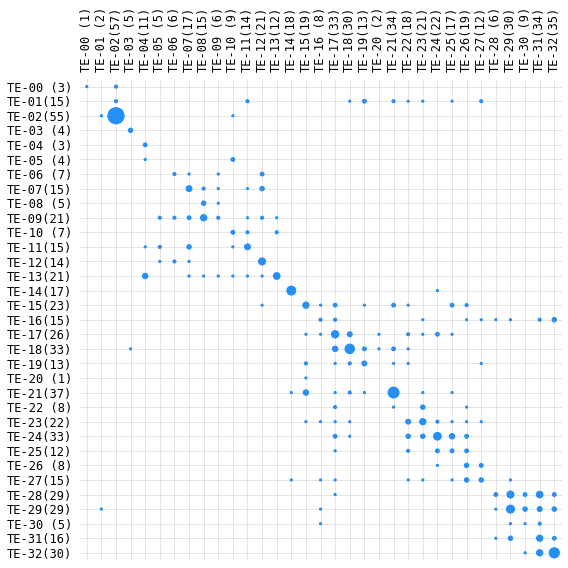

In [18]:
for cv in [11]:
    xlabelc = ['TE-{:02d}{:>4s}'.format(x,'({:d})'.format(np.sum(CVdict[cv]['ccT_lbl_matched'][CVdict[cv]['cc_inds']]==x))) for x in np.arange(best_n_components)]
    ylabelc = ['TE-{:02d}{:>4s}'.format(y,'({:d})'.format(np.sum(CVdict[cv]['ccE_lbl_matched'][CVdict[cv]['cc_inds']]==y))) for y in np.arange(best_n_components)]
    custom_scatterplot(M=CVdict[cv]['C_consistency'],scale_factor=5,
                       xlabels=xlabelc,
                       ylabels=ylabelc,
                       fig_width=8,fig_height=8)

    #plt.savefig('/home/common/Rohan/docs/Consensus_cluster_TE_cv_{:d}_zT_n_{:d}.png'.format(cv,best_n_components),dpi=300)
    plt.show()

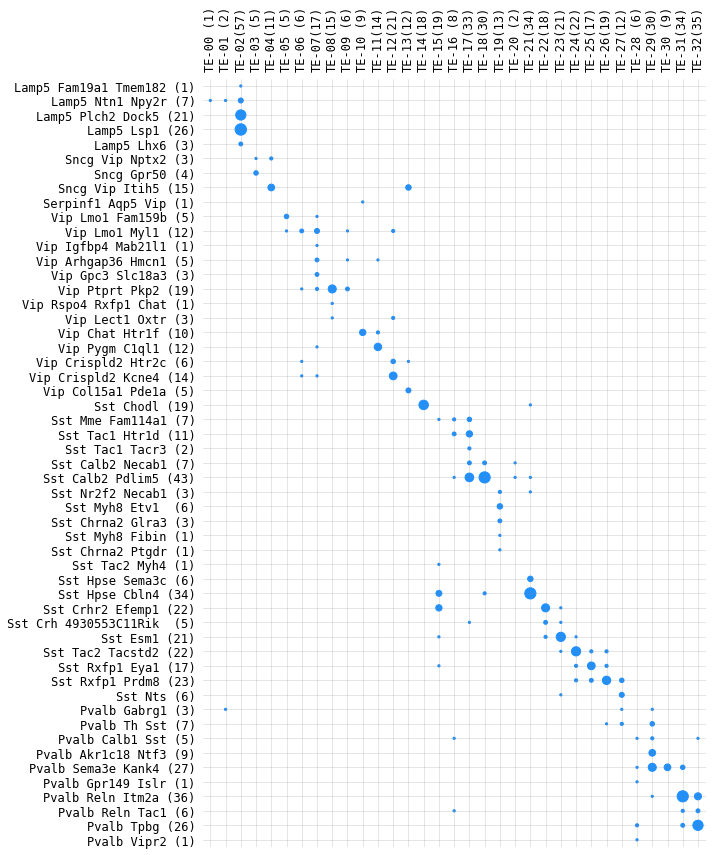

In [21]:
for cv in [11]:
    xlabelc = ['TE-{:02d}{:>4s}'.format(x,'({:d})'.format(np.sum(CVdict[cv]['ccT_lbl_matched'][CVdict[cv]['cc_inds']]==x))) for x in np.arange(best_n_components)]
    ylabelc = ['{} ({:d})'.format(y,np.sum(O['cluster'][CVdict[cv]['cc_inds']]==y)) for y in t_types_well_sampled]
    
    custom_scatterplot(M=CVdict[cv]['C_t_type'],scale_factor=5,
                    xlabels=xlabelc,
                    ylabels=ylabelc,
                    fig_width=10,fig_height=12)
    #plt.savefig('/home/common/Rohan/docs/Consensus_cluster_vs_t_type_cv_{:d}_zTzE_n_{:d}.png'.format(cv,best_n_components),dpi=300)
    plt.show()
    


In [32]:
sio.savemat('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/consensus_cluster.mat',
            {'consensus_cluster':np.array([f'TE-{x:02d}' for x in CVdict[11]['ccT_lbl_matched']]),
            'consensus_cluster_id':CVdict[11]['ccT_lbl_matched']})

In [38]:
X = CVdict[cv]['C_t_type']/np.expand_dims(np.sum(CVdict[cv]['C_t_type'],axis=1),axis=-1)
ylabels = list(reversed(ylabelc))
xlabels = xlabelc

for i in range(X.shape[1]):
    j = np.argmax(X[:,i])
    print(xlabels[i],ylabels[j])
    X[:,i]=0

TE-00(34) Lamp5 Lhx6 (14)
TE-01(37) Lamp5 Ntn1 Npy2r (50)
TE-02(288) Lamp5 Lsp1 (142)
TE-03(43) Sncg Gpr50 (18)
TE-04(43) Sncg Vip Itih5 (77)
TE-05(31) Vip Lmo1 Fam159b (24)
TE-06(46) Vip Lmo1 Myl1 (69)
TE-07(93) Vip Gpc3 Slc18a3 (16)
TE-08(73) Vip Ptprt Pkp2 (103)
TE-09(66) Vip Igfbp4 Mab21l1 (18)
TE-10(51) Vip Chat Htr1f (53)
TE-11(81) Vip Pygm C1ql1 (69)
TE-12(95) Vip Crispld2 Kcne4 (85)
TE-13(80) Vip Col15a1 Pde1a (28)
TE-14(98) Sst Chodl (105)
TE-15(88) Sst Mme Fam114a1 (36)
TE-16(72) Pvalb Calb1 Sst (15)
TE-17(137) Sst Tac1 Tacr3 (11)
TE-18(174) Sst Calb2 Pdlim5 (221)
TE-19(84) Sst Myh8 Etv1  (38)
TE-20(26) Sst Chrna2 Glra3 (14)
TE-21(190) Sst Hpse Sema3c (43)
TE-22(105) Sst Crhr2 Efemp1 (111)
TE-23(107) Sst Esm1 (105)
TE-24(104) Sst Tac2 Tacstd2 (107)
TE-25(83) Sst Rxfp1 Eya1 (82)
TE-26(81) Sst Rxfp1 Prdm8 (127)
TE-27(80) Sst Nts (33)
TE-28(110) Pvalb Vipr2 (14)
TE-29(139) Pvalb Akr1c18 Ntf3 (44)
TE-30(44) Pvalb Sema3e Kank4 (139)
TE-31(146) Pvalb Reln Itm2a (188)
TE-32(156) Pva

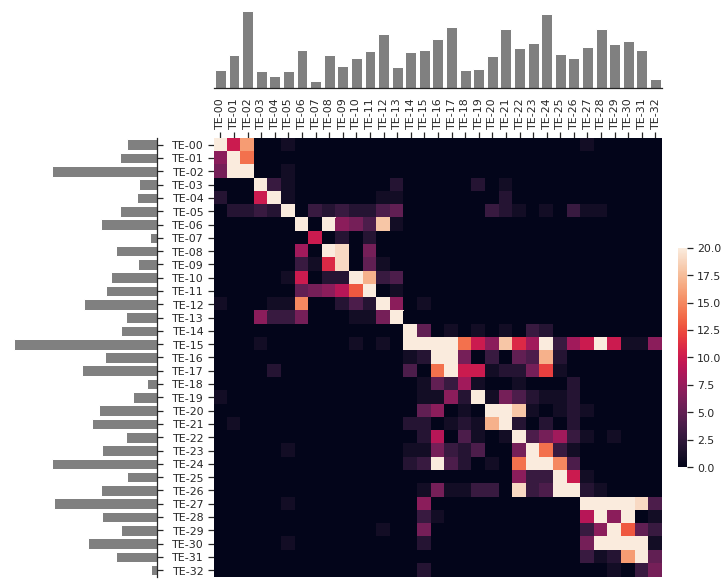

In [34]:
TE_labels_denovo = ['TE-{:02d}'.format(n) for n in np.arange(0,best_n_components).tolist()]
custom_heatmap(M=CVdict[cv]['C_consistency'],
                xlabels=TE_labels_denovo,
                ylabels=TE_labels_denovo,
                xdat=CVdict[cv]['ccT_lbl_matched'][CVdict[cv]['cc_inds']],
                xdat_label_order=np.arange(0,best_n_components),
                ydat=CVdict[cv]['ccE_lbl_matched'][CVdict[cv]['cc_inds']],
                ydat_label_order=np.arange(0,best_n_components),
                fig_width=10,fig_height=8,
                vmin=0,vmax=20)

In [ ]:
TE_labels_denovo = ['TE-{:02d}'.format(n) for n in np.arange(0,best_n_components).tolist()]
custom_heatmap(M=CVdict[cv]['C_consistency'],
                xlabels=TE_labels_denovo,
                ylabels=TE_labels_denovo,
                xdat=CVdict[cv]['ccT_lbl_matched'][CVdict[cv]['cc_inds']],
                xdat_label_order=np.arange(0,best_n_components),
                ydat=CVdict[cv]['ccE_lbl_matched'][CVdict[cv]['cc_inds']],
                ydat_label_order=np.arange(0,best_n_components),
                fig_width=10,fig_height=8,
                vmin=0,vmax=20)

**Consistency across the modalities, after aligning the unsupervised types with t-types**

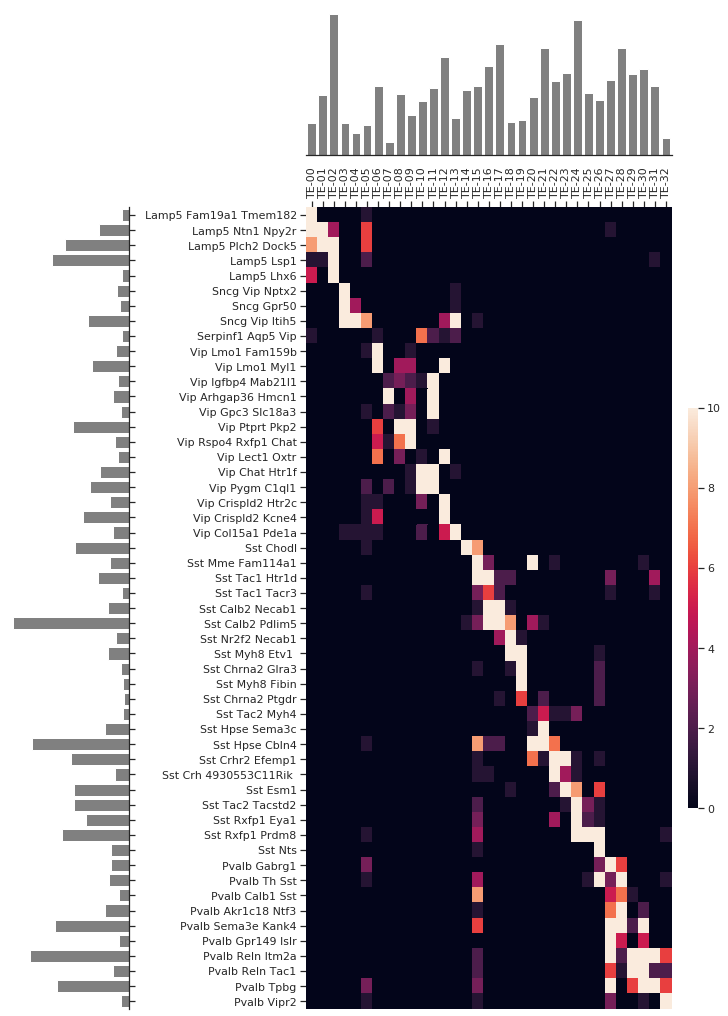

In [33]:
TE_labels_denovo = ['TE-{:02d}'.format(n) for n in np.arange(0,best_n_components).tolist()]
#ax = sns.heatmap(Combined_C,annot=False,vmin=0,vmax=10,cbar_kws={"aspect":30,"shrink":.9})
custom_heatmap(M=CVdict[cv]['C_t_type'],
                xlabels=TE_labels_denovo,
                ylabels=t_types_well_sampled,
                xdat=CVdict[cv]['ccT_lbl_matched'][CVdict[cv]['cc_inds']],
                xdat_label_order= np.arange(0,best_n_components),
                ydat=t_type_labels[CVdict[cv]['cc_inds']],
                ydat_label_order=t_types_well_sampled,
                fig_width=10,fig_height=14,
                vmin=0,vmax=10)

array(['Vip Gpc3 Slc18a3', 'Sst Calb2 Pdlim5', 'Sst Hpse Cbln4', ...,
       'Lamp5 Fam19a1 Pax6', 'Sncg Vip Nptx2', 'Sncg Vip Itih5'],
      dtype=object)

**Pooled results**

**Consistency across T-E, unsupervised types are matched with t-types**

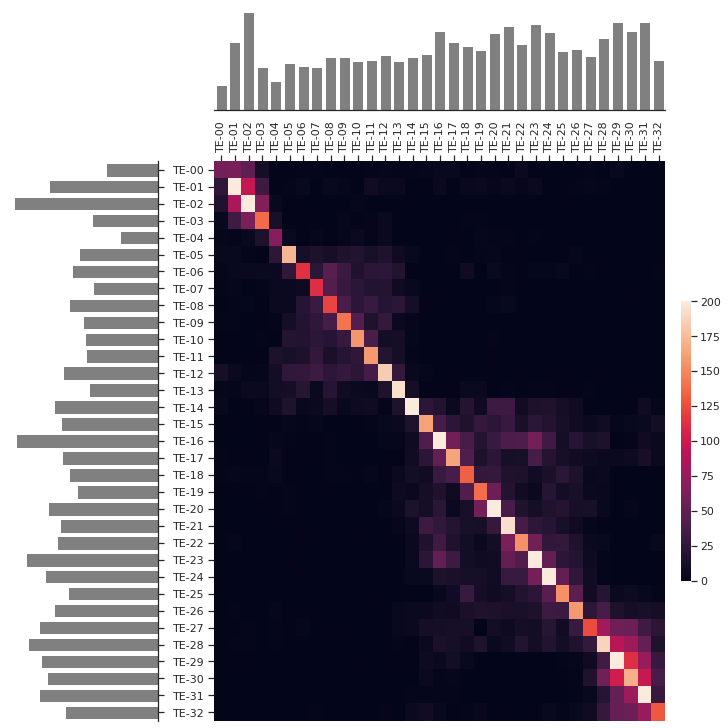

In [40]:
TE_labels_denovo = ['TE-{:02d}'.format(n) for n in np.arange(0,best_n_components).tolist()]
#ax = sns.heatmap(Combined_C,annot=False,vmin=0,vmax=10,cbar_kws={"aspect":30,"shrink":.9})
custom_heatmap(M=Combined_C_consistency,
                xlabels=TE_labels_denovo,
                ylabels=TE_labels_denovo,
                xdat=Combined_ccT_lbl,
                xdat_label_order=np.arange(0,best_n_components),
                ydat=Combined_ccE_lbl,
                ydat_label_order=np.arange(0,best_n_components),
                fig_width=10,fig_height=10,
                vmin=0,vmax=200)

(71631,)

**Consistency with t-types**

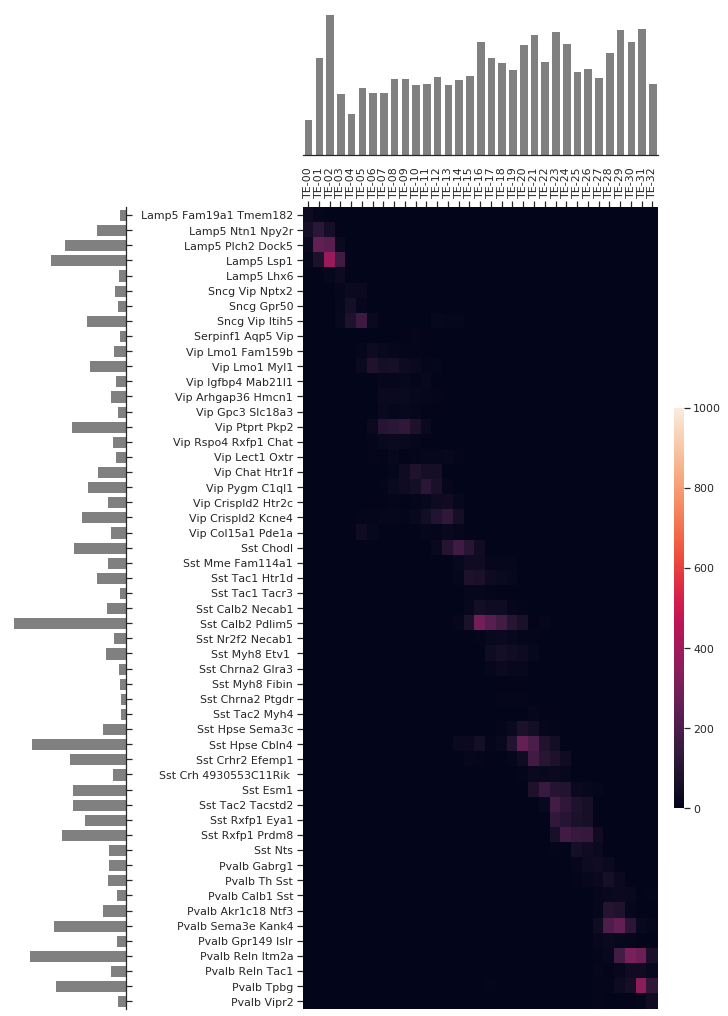

In [41]:
TE_labels_denovo = ['TE-{:02d}'.format(n) for n in np.arange(0,best_n_components).tolist()]
#ax = sns.heatmap(Combined_C,annot=False,vmin=0,vmax=10,cbar_kws={"aspect":30,"shrink":.9})
custom_heatmap(M=Combined_C_t_type,
                xlabels=TE_labels_denovo,
                ylabels=t_types_well_sampled,
                xdat=Combined_ccT_lbl,
                xdat_label_order= np.arange(0,best_n_components),
                ydat=t_type_labels,
                ydat_label_order=t_types_well_sampled,
                fig_width=10,fig_height=14,
                vmin=0,vmax=1000)

'TE-00'

In [96]:
np.sum(Combined_C_t_type.sum(axis=1))

14217.0

In [ ]:
def set_ME_labels(O):
    import scipy.io as sio
    import pandas as pd

    dir_pth = {}
    #/allen/programs/celltypes/workgroups/ivscc/nathang/me_clust_output/inh_met_mouse_me_clustering/refined_text_labels.csv
    dir_pth['data'] = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
    ME = pd.read_csv(dir_pth['data']+'refined_text_labels.csv')
    ME.columns = ['spec_id_label','cluster']
    MEdict = {'spec_id_label':ME['spec_id_label'].values,'cluster':ME['cluster'].values}w

    ind = np.isin(O['E_spec_id_label'],MEdict['spec_id_label'])
    print('{:d} cells have ME labels'.format(np.sum(ind)))
    O['ME_cluster'] = np.array(['NA']*np.size(O['E_spec_id_label']),dtype='object')
    for e in O['E_spec_id_label']:
        set_ind = (MEdict['spec_id_label']==e)
        if np.sum(set_ind)==1:
            O['ME_cluster'][O['E_spec_id_label']==e] = MEdict['cluster'][set_ind]
    return O

In [124]:
O['cluster']

array(['Vip Gpc3 Slc18a3', 'Sst Calb2 Pdlim5', 'Sst Hpse Cbln4', ...,
       'Lamp5 Fam19a1 Pax6', 'Sncg Vip Nptx2', 'Sncg Vip Itih5'],
      dtype=object)

In [121]:
from data_funcs import *
